# Modelling X-ray attenuation

Using python to simulate how an X-ray beam is attenuated, using the Beer-Lambert law, and visualising the resulting attenuation profiles.

### Single-layer attenuation
**Beer-Lambert Law**: <br>
$ I = I_0 \cdot e^{\mu x} $

Where: <br>
- I: intensity after passing through material
- $I_0$ : Initial intensity
- $\mu$ : Linear attenuation coefficient
- $x$ : Thickness 

This is easily generalised to multiple layers, however one key limitation is that this assumes monochromatic electromagnetic radiation is used. In x-ray imaging, we observe 'beam hardening', when the x-ray beam comprised of polychromatic energies passes through the object. As the high energy 'hard' x-rays, can penetrate denser materials better than 'soft' x-rays. 

I decided to download a python library SpekPy to model the radiation spectra from x ray tubes. [A validation of SpekPy](https://www.sciencedirect.com/science/article/pii/S1120179720301083?via%3Dihub)

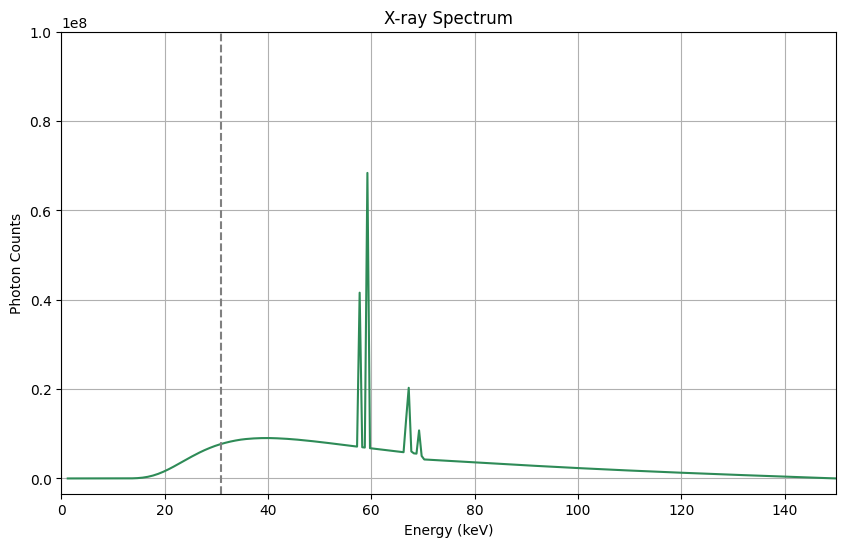

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import spekpy as sp

s = sp.Spek(kvp=150,th=12) # Generate a spectrum (150 kV, 12 degree tube angle)

s.filter('Al', 2.0)

energies = s.get_k() # get energy bins
photon_counts = s.get_spk() # get photon counts

plt.figure(figsize=(10, 6)) 
plt.plot(energies, photon_counts, linestyle='-', color='seagreen')
plt.xlim(0, 150)
plt.ylim(top=1e8)
plt.axvline(x=31, color='gray', linestyle='--')
plt.xlabel("Energy (keV)")
plt.ylabel("Photon Counts")
plt.title("X-ray Spectrum")
plt.grid(True)
plt.show()

The default target material SpekPy uses is Tungesten. [Resource I used](https://doi.org/10.1002/mp.14945)

The sharp peaks correspond to Tungestens characteristic radiations [Guide](https://rigaku.com/products/imaging-ndt/x-ray-ct/learning/blog/what-is-beam-hardening-in-ct)

Ignoring these peaks we can see the peak is around 31 keV. I have restricted the values of the energy spectrum to avoid the high peaks at low energies. These sharp peaks are monochromatic- so we don't expect to see any beam hardening. At this point I could use SpekPy's filter function in order to simulate the x-rays interacting with a material, but I would like to try implement this myself.

I copied in some attenuation coefficients for bone from [NIST](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/bone.html) and had to interpolate the data as I had less data points for attenuation coefficients.

Original peak: 39.8 keV
After bone attenuation: 49.8 keV


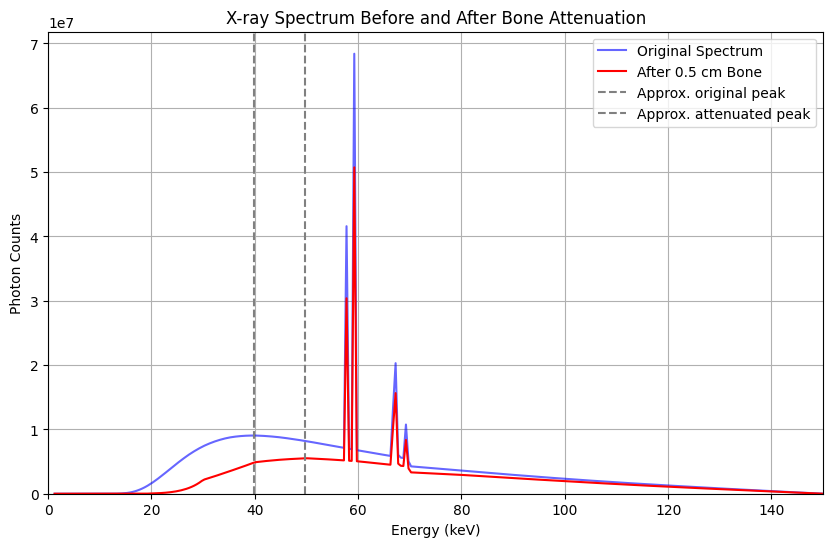

In [33]:
import pandas as pd
from scipy.interpolate import interp1d

# Load csv
bone_data = pd.read_csv("bone.csv", names=["Energy_MeV", "Mu_Rho"], header=None)#

# Convert energy to KeV
bone_data["Energy_KeV"] = bone_data["Energy_MeV"] * 1000

# Average out duplicates by grouping
bone_data = bone_data.groupby("Energy_KeV", as_index=False).mean()

# Convert to linear attenuation (mu = mu/rho * rho)
bone_density = 1.85  # g/cm^3
bone_data["Mu"] = bone_data["Mu_Rho"] * bone_density  # [cm^-1]
mu = bone_data["Mu"].to_numpy()

# Create interpolation function for attenuation coefficients
mu_interp = interp1d(bone_data["Energy_KeV"], bone_data["Mu"], bounds_error=False, fill_value="extrapolate")

mu_at_spectrum_energies = mu_interp(energies)

thickness_cm = 0.5
I0 = s.get_spk()

I_filtered = I0 * np.exp(-mu_at_spectrum_energies * thickness_cm)

# Mask to energies below 50 keV (to avoid tungsten peaks)
mask = (energies < 50)
E0_peak = energies[mask][np.argmax(I0[mask])]
E1_peak = energies[mask][np.argmax(I_filtered[mask])]

print(f"Original peak: {E0_peak:.1f} keV")
print(f"After bone attenuation: {E1_peak:.1f} keV")

plt.figure(figsize=(10, 6))
plt.plot(energies, I0, label="Original Spectrum", color="blue", alpha=0.6)
plt.plot(energies, I_filtered, label="After 0.5 cm Bone", color="red")
plt.axvline(x=E0_peak, color='gray', linestyle='--', label="Approx. original peak")
plt.axvline(x=E1_peak, color='gray', linestyle='--', label="Approx. attenuated peak")
plt.xlabel("Energy (keV)")
plt.ylabel("Photon Counts")
plt.title("X-ray Spectrum Before and After Bone Attenuation")
plt.grid(True)
plt.legend()
plt.xlim(0, 150)
plt.ylim(bottom=0)
plt.show()


My next goal is to generalise this to multiple materials, using:<br>

$I = I_0 \cdot e^{- \sum_{i}^{} \mu_i (E) \cdot d_i}$

I first wrote a function repeating what I had done so that I could load NIST data for other materials, provided I made a csv file for them.

[NIST Soft Tissue](https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/tissue.html)

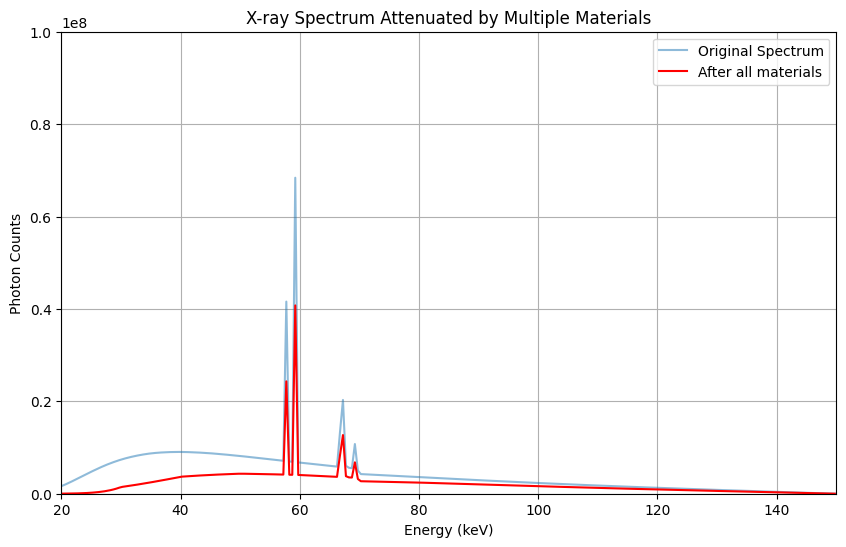

In [8]:
def load_mu_data(csv_path, density, energy_range_KeV):
    import pandas as pd
    from scipy.interpolate import interp1d

    df = pd.read_csv(csv_path, names=["Energy_MeV", "Mu_Rho"], header=None)
    df["Energy_keV"] = df["Energy_MeV"] * 1000
    df = df.groupby("Energy_keV", as_index=False).mean()
    df["Mu"] = df["Mu_Rho"] * density

    interp_mu = interp1d(df["Energy_keV"], df["Mu"], bounds_error=False, fill_value="extrapolate")
    return interp_mu(energy_range_KeV)

energies = s.get_k()  # energy array (keV)

# Load each material
mu_bone = load_mu_data("bone.csv", density=1.85, energy_range_KeV=energies)
mu_tissue = load_mu_data("soft_tissue.csv", density=1.06, energy_range_KeV=energies)


# Define thicknesses (cm)
thickness_bone = 0.5
thickness_tissue = 1.0

# Total attenuation coefficient
mu_total = np.add((mu_bone*thickness_bone),(mu_tissue*thickness_tissue))

# Apply Beer-Lambert
I0 = s.get_spk()
I_filtered = I0 * np.exp(-mu_total)


plt.figure(figsize=(10, 6))
plt.plot(energies, I0, label="Original Spectrum", alpha=0.5)
plt.plot(energies, I_filtered, label="After all materials", color="red")
plt.xlabel("Energy (keV)")
plt.ylabel("Photon Counts")
plt.title("X-ray Spectrum Attenuated by Multiple Materials")
plt.xlim(20, 150)
plt.ylim(bottom=0,top=1e8)
plt.grid(True)
plt.legend()
plt.show()

The next goal for me was to recreate a simple 2D cross-section of tissue (phantom), and simulate how an X-ray beam (coming from top down) would attenuate as it passes through it from one side.

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


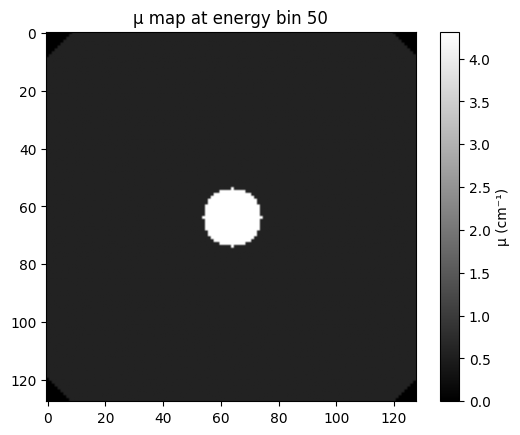

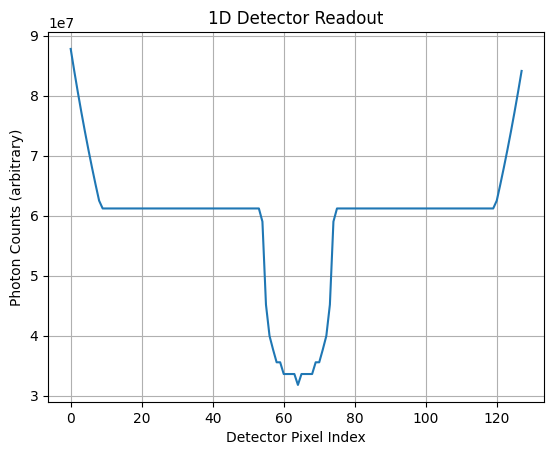

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# image size
width, height = 128,128
E = len(energies)

# Add a circular bone
y, x = np.ogrid[:height, :width]
center_x, center_y = width//2, height//2
boneradius = 10
thighradius = 84.5
bonemask = (x-center_x)**2 + (y-center_y)**2 <= boneradius**2

phantom = np.zeros((height, width, E))

thighmask = (x-center_x)**2 + (y-center_y)**2 <= thighradius**2

# Background
phantom[:, :, :] = 0  # broadcast over all pixels

# Thigh region
phantom[thighmask, :] = mu_tissue

# Bone region
phantom[bonemask, :] = mu_bone    # assign bone

energy_idx = 50  # e.g. energy bin index
plt.imshow(phantom[:, :, energy_idx], cmap='gray')
plt.title(f"μ map at energy bin {energy_idx}")
plt.colorbar(label="μ (cm⁻¹)")
plt.show()

voxel_thickness_cm = 0.1 # Assume each pixel is 0.1cm thick
mu_total = phantom.sum(axis=0)

I = I0 * np.exp(-mu_total * voxel_thickness_cm)

detector_readout = I.sum(axis=1)

plt.plot(detector_readout)
plt.title("1D Detector Readout")
plt.xlabel("Detector Pixel Index")
plt.ylabel("Photon Counts (arbitrary)")
plt.grid(True)
plt.show()

I then just needed to rotate the image using scipy and I have recreated a ct scan. The challenge in this, is reconstructing the scan https://rigaku.com/products/imaging-ndt/x-ray-ct/learning/blog/how-does-ct-reconstruction-work

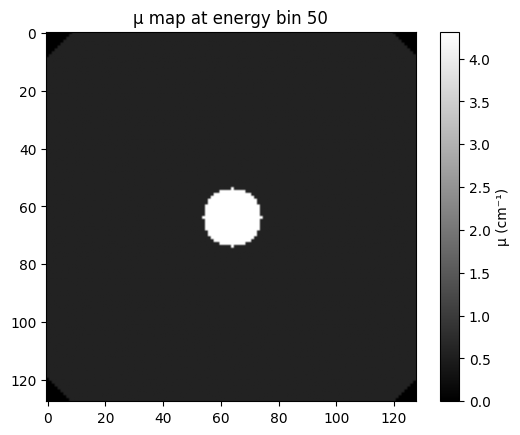

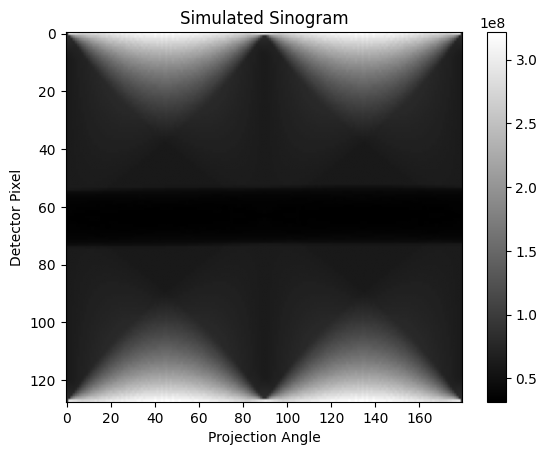

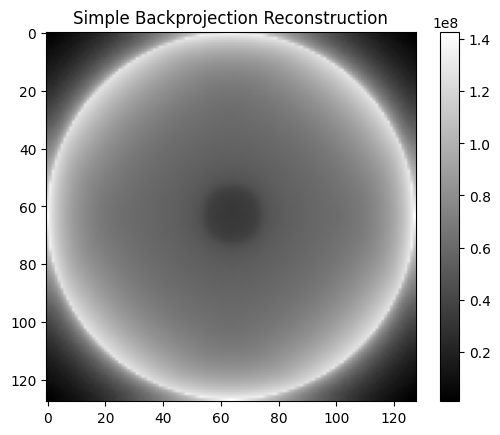

In [31]:
from scipy import ndimage

plt.imshow(phantom[:, :, energy_idx], cmap='gray')
plt.title(f"μ map at energy bin {energy_idx}")
plt.colorbar(label="μ (cm⁻¹)")
plt.show()

angles = np.linspace(0, 180, num=180)
sinogram = np.zeros((len(angles), width))

for i, angle in enumerate(angles):
    # Rotate all energy slices at once using 3D rotation
    rotated_phantom = ndimage.rotate(phantom, angle, axes=(1, 0), reshape=False, order=1)
    
    # Sum along y-axis for all energy slices (results in (width, E) array)
    projection_per_energy = rotated_phantom.sum(axis=1)
    
    # Apply attenuation and sum
    I_rotated = I0 * np.exp(-projection_per_energy * voxel_thickness_cm)
    sinogram[i] = I_rotated.sum(axis=1)  # sum over energy bins

sinogram = np.array(sinogram)  # shape: (n_angles, W)

plt.imshow(sinogram.T, cmap='gray', aspect='auto')
plt.title("Simulated Sinogram")
plt.ylabel("Detector Pixel")
plt.xlabel("Projection Angle")
plt.colorbar()
plt.show()

# Initialize reconstruction
reconstruction = np.zeros((width, height))

# Backproject each angle's projection
for i, angle in enumerate(angles):
    # Expand the 1D projection into a 2D image by smearing along the angle
    projection = sinogram[i]
    expanded = np.tile(projection, (width, 1))  # Repeat along y-axis
    
    # Rotate back to original angle and accumulate
    rotated_back = ndimage.rotate(expanded, -angle, reshape=False, order=1)
    reconstruction += rotated_back

# Normalize
reconstruction /= len(angles)

plt.imshow(reconstruction, cmap='gray')
plt.title("Simple Backprojection Reconstruction")
plt.colorbar()
plt.show()